# Visualizing Style with expert.ai's Writeprint

In this Notebook you'll find instructions on how to perform a basic yet comprehensive stylometric analysis of multiple texts using [Writeprint](https://docs.expert.ai/nlapi/latest/guide/detection/writeprint/), one of the built-in features of the expert.ai Natural Language API. For a more extensive discussion of this project and its results, please have a look at my article on Medium.

In [1]:
import time
import os
import nltk
import pandas as pd
import numpy as np
import re
import squarify
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from dotenv import load_dotenv
from expertai.nlapi.cloud.client import ExpertAiClient

To try out the capabilities of Writeprint, we will work on the [Spooky Author Identification](https://www.kaggle.com/c/spooky-author-identification) dataset, which the [Kaggle](https://www.kaggle.com/) team put together for one of the website’s competitions.
This dataset consists of two pandas DataFrames, both of which contain several thousand sentences drawn from the works of three so-called “spooky” authors: [Edgar Allan Poe](https://en.wikipedia.org/wiki/Edgar_Allan_Poe), [H. P. Lovecraft](https://en.wikipedia.org/wiki/H._P._Lovecraft), and [Mary Shelley](https://en.wikipedia.org/wiki/Mary_Shelley).

In [2]:
train = pd.read_csv("train.csv")
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


Having downloaded the dataset, we begin by creating three string objects containing all the lines associated with each one of the three writers in the dataset.

In [3]:
extract_txt = lambda extract_txt: " ".join(list(train[train["author"] == extract_txt].text))

mws_txt = extract_txt("MWS")
hpl_txt = extract_txt("HPL")
eap_txt = extract_txt("EAP")

Since the expert.ai NL API is designed to process chunks of text [that do not exceed 10 kB in size](https://github.com/therealexpertai/nlapi-python#apis-capabilites), we can create a small function that splits these long strings into lists of shorter strings. By using an [nltk tokenizer](https://www.nltk.org/api/nltk.tokenize.html), we can make sure that these shorter strings will contain only full sentences.

In [4]:
def chunker(full_text, chunk_size=9000):
    tokenized_text = nltk.tokenize.sent_tokenize(full_text)
    chunked_text = []
    while len(tokenized_text) > 0:
        character_sum = 0
        chunk = []
        counter = 0
        while character_sum <= chunk_size:
            try:
                chunk.append(tokenized_text[counter])
                character_sum += len(tokenized_text[counter])
                counter += 1
            except IndexError:
                break
        chunked_text.append(" ".join(chunk))
        tokenized_text = tokenized_text[counter:]
    return chunked_text

Now we’re ready to access the expert.ai NL API and retrieve our Writeprint indexes. To configure the API on your own system, you can follow the instructions contained in Laura Gorrieri’s excellent [article on topic modelling with expert.ai](https://towardsdatascience.com/visualizing-what-docs-are-really-about-with-expert-ai-cd537e7a2798).
(Please note that I have used [python-dotenv](https://pypi.org/project/python-dotenv/) to set my expert.ai credentials as environment variables; please read the [documentation](https://github.com/theskumar/python-dotenv) to know how to do so.)

In [5]:
load_dotenv()
client = ExpertAiClient()

Once we have accessed the API, we can use a function that sends it one chunk of text at a time, storing all the relevant Writeprint responses in a dedicated list. We will then be able to process all these values however we need.

In [6]:
def make_one_writeprint(string):
    return client.detection(
        body={"document": {"text": string}},
        params={"detector": "writeprint", "language": "en"})


def make_writeprints(long_text, divisor=5, chunk_size=9000,
                     wait_time=10, chunk_start=0, selections=True):
    chunked_text = chunker(long_text, chunk_size)
    if selections:
        chunked_text = chunked_text[chunk_start::int(len(chunked_text) / divisor)]
        # If this option is enabled, the function will only apply to a specific
        # selection of the text, whose size and starting point can be specified by the user.
    all_writeprints = []
    counter = 1
    for chunk in chunked_text:
        all_writeprints.append(make_one_writeprint(chunk))
        time.sleep(wait_time) # This optional wait time reduces the possibility
                              # of connection errors when accessing the API.
        print(f"{counter} of {len(chunked_text)} chunks processed.")
        counter += 1
    return all_writeprints


spooky_writeprints = [make_writeprints(eap_txt), make_writeprints(hpl_txt), make_writeprints(mws_txt)]
spooky_names = ["Edgar Allan Poe", "H. P. Lovecraft", "Mary Shelley"]

1 of 6 chunks processed.
2 of 6 chunks processed.
3 of 6 chunks processed.
4 of 6 chunks processed.
5 of 6 chunks processed.
6 of 6 chunks processed.
1 of 6 chunks processed.
2 of 6 chunks processed.
3 of 6 chunks processed.
4 of 6 chunks processed.
5 of 6 chunks processed.
6 of 6 chunks processed.
1 of 6 chunks processed.
2 of 6 chunks processed.
3 of 6 chunks processed.
4 of 6 chunks processed.
5 of 6 chunks processed.
6 of 6 chunks processed.


For each chunk of text, the API returns a [JSON object](https://docs.expert.ai/nlapi/latest/reference/output/detection/writeprint/) listing all the 60 indexes of Writeprint and the corresponding values. These values can be extracted by accessing the `extra_data` property contained in the Writeprint object, as shown in the two functions below.

In [7]:
def extract_structure_feature(writeprint_object, feature_name, value="mean"):
    return writeprint_object.extra_data[
        "JSON-LD"]["@graph"][0]["structureIndexes"][feature_name][value]


def extract_readability_index(writeprint_object, index_number):
    return (writeprint_object.extra_data[
        "JSON-LD"]["@graph"][0]["readabilityIndexes"][index_number]["name"],
            writeprint_object.extra_data[
                "JSON-LD"]["@graph"][0]["readabilityIndexes"][index_number]["value"])

The 60 indexes returned by Writeprint convey a lot of information, so navigating through them all can feel quite daunting at first. As you start planning your analysis, I strongly suggest that you follow the index categorization put forward in the [official API docs](https://docs.expert.ai/nlapi/latest/guide/detection/writeprint/#readability-indexes). You can, for instance, create ad hoc lists of Writeprint indexes to analyze one facet of the text at a time: grammar, punctuation, vocabulary, and so on.

In [8]:
VARIETY = ['verbTypesPerSentence', 'namedEntitiesPerSentence', 'unknownConceptsPerSentence',
           'commonlyMisspelledWordsPerSentence', 'functionWordsPerSentence',
           'mostCommonWordsPerSentence']
LENGTHS = ['tokenLengthPerSentence', 'charactersPerSentence', 'atomsPerSentence',
           'tokensPerSentence', 'phrasesPerSentence']
PHRASES = ['adjectivePhrasesPerSentence', 'conjunctionPhrasesPerSentence',
           'adverbPhrasesPerSentence', 'nounPhrasesPerSentence', 'nominalPredicatesPerSentence',
           'prepositionPhrasesPerSentence', 'relativePhrasesPerSentence', 'verbPhrasesPerSentence']
POS = ['adjectivesPerSentence', 'adverbsPerSentence', 'articlesPerSentence', 'auxiliariesPerSentence',
       'conjunctionsPerSentence', 'nounsPerSentence', 'properNounsPerSentence',
       'prepositionsPerSentence', 'pronounsPerSentence', 'particlesPerSentence', 'verbsPerSentence']
PUNCTUATION = ['punctuationPerSentence', 'colonsPerSentence', 'commasPerSentence', 'dotsPerSentence',
               'doubleQuotationMarksPerSentence', 'exclamationMarksPerSentence',
               'exclamationMarkQuestionMarkSequencesPerSentence', 'multipleDotsPerSentence',
               'multipleExclamationMarksPerSentence', 'multipleQuestionMarksPerSentence',
               'questionMarksPerSentence', 'semicolonsPerSentence', 'singleQuotationMarksPerSentence']
PUNCTUATION_SHORT = ['colonsPerSentence', 'commasPerSentence', 'doubleQuotationMarksPerSentence',
                     'exclamationMarksPerSentence', 'questionMarksPerSentence',
                     'semicolonsPerSentence']
VOCABULARY = ['emoticonsPerSentence', 'academicLanguageWordsPerSentence',
              'businessLanguageWordsPerSentence', 'crimeLanguageWordsPerSentence',
              'laymanLanguageWordsPerSentence', 'legalLanguageWordsPerSentence',
              'militaryLanguageWordsPerSentence',
              'politicalLanguageWordsPerSentence', 'socialMediaLanguageWordsPerSentence']
VOCABULARY_SHORT = ['academicLanguageWordsPerSentence', 'businessLanguageWordsPerSentence',
                    'crimeLanguageWordsPerSentence', 'laymanLanguageWordsPerSentence',
                    'legalLanguageWordsPerSentence', 'militaryLanguageWordsPerSentence',
                    'politicalLanguageWordsPerSentence']
READABILITY = ["Gulpease", "Automated Readability Index", "Coleman-Liau"]

Having picked a set of indexes, we can now access the lists of Writeprint objects that we have created and then extract and process the relevant values. These values can be stored in dictionaries: the dictionary keys will be the names of the relevant stylometric indexes, and the values will be their totals or averages. Since we want to compare multiple writers, and since each dictionary corresponds to a single writer, we will store all these dictionaries in a single list.

In [9]:
def normalize_writeprint_dictionaries(writeprint_dictionaries):
    normalized_writeprint_dictionaries = [dict() for one_dictionary in writeprint_dictionaries]
    for feature_name in list(writeprint_dictionaries[0].keys()):
        values = [dictionary[feature_name] for dictionary in writeprint_dictionaries]
        normalized_values = [value / max(values) if max(values) > 0 else 0 for value in values]
        for x in range(len(normalized_values)):
            normalized_writeprint_dictionaries[x][feature_name] = normalized_values[x]
    return normalized_writeprint_dictionaries


def writeprints_to_dictionary(writeprints_list, value="mean", average=True):
    return [
        make_dictionary_from_writeprints(
            writeprint, value=value, average=average) for writeprint in writeprints_list]


def writeprints_to_selected_dictionaries(writeprints_list, feature_names,
                                               value="mean", average=True, normalize=False):
    writeprint_dictionaries = writeprints_to_dictionary(writeprints_list,
                                                        value=value, average=average)
    if normalize:
        writeprint_dictionaries = normalize_writeprint_dictionaries(writeprint_dictionaries)
    return [{feature: value for feature, value in dictionary.items() if feature in feature_names}
            for dictionary in writeprint_dictionaries]


def make_dictionary_from_writeprints(multiple_writeprints, value="mean", average=True):
    dictionary = {}
    feature_names = list(
        multiple_writeprints[0].extra_data["JSON-LD"]["@graph"][0]["structureIndexes"].keys())
    for readability_index_number in range(3):
        values_sum = 0
        readability_index_name = ""
        for writeprint in multiple_writeprints:
            readability_index_name, one_value = extract_readability_index(
                writeprint, readability_index_number)
            values_sum += one_value
        dictionary[readability_index_name] = values_sum / len(multiple_writeprints)
    for feature_name in feature_names:
        values_sum = 0
        for writeprint in multiple_writeprints:
            try:
                one_value = extract_structure_feature(writeprint, feature_name, value=value)
            except KeyError:
                other_value = "total" if value == "mean" else "mean"
                one_value = extract_structure_feature(writeprint, feature_name, value=other_value)
            values_sum += one_value
        dictionary[feature_name] = values_sum / len(multiple_writeprints) if average else values_sum
    return dictionary

The functions below are used to access and process the values contained in the dictionaries.

In [10]:
def sort_dictionaries(selected_dictionaries):
    one_sorted_dictionary = {k: v for k, v in sorted(selected_dictionaries[0].items(),
                                               key=lambda item: item[1], reverse=True)}
    return [{k: dictionary[k] for k in list(
        one_sorted_dictionary.keys())} for dictionary in selected_dictionaries]


def make_values_labels(dictionary, value_limit=0):
    labels = []
    values = []
    for label, value in dictionary.items():
        if value > value_limit:
            values.append(value)
            labels.append(transform_feature_name(label))
    return values, labels


def transform_feature_name(feature_name):
    return re.sub(r"([A-Z])", r" \1", re.sub(r"(Phrases)*PerSentence", "", feature_name)).title()

Now that the data is neatly organized, all that remains is visualizing it. Here are some examples of how you can do it effectively. Moreover, you can use the inspiring [Python Graph Gallery](https://www.python-graph-gallery.com/) to look for more ideas and tutorials (much of the code you will find below is adapted from there).

## Circular Bar Plots

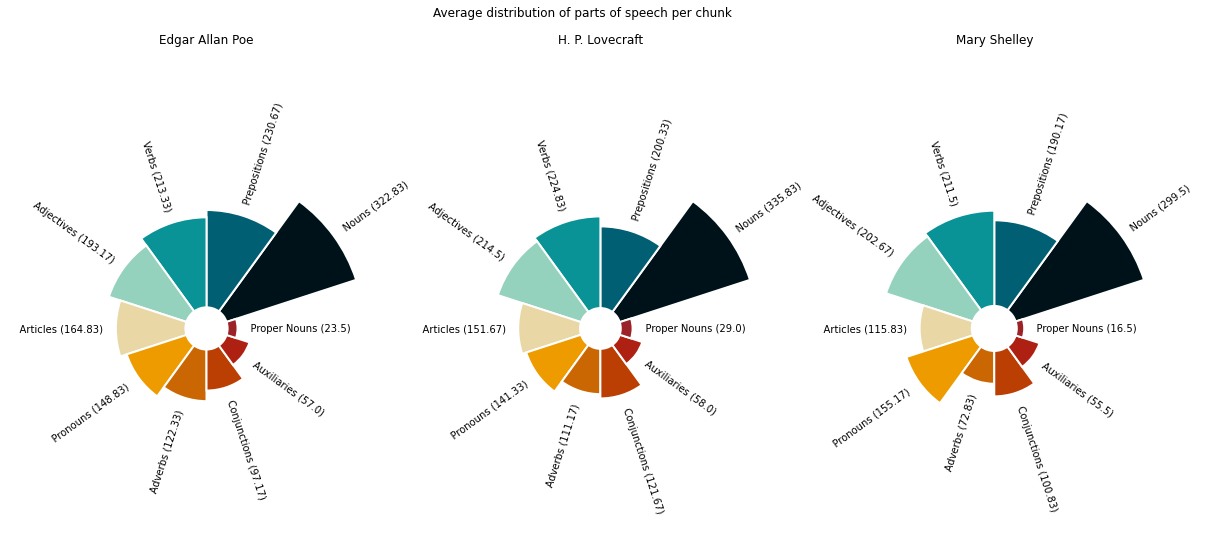

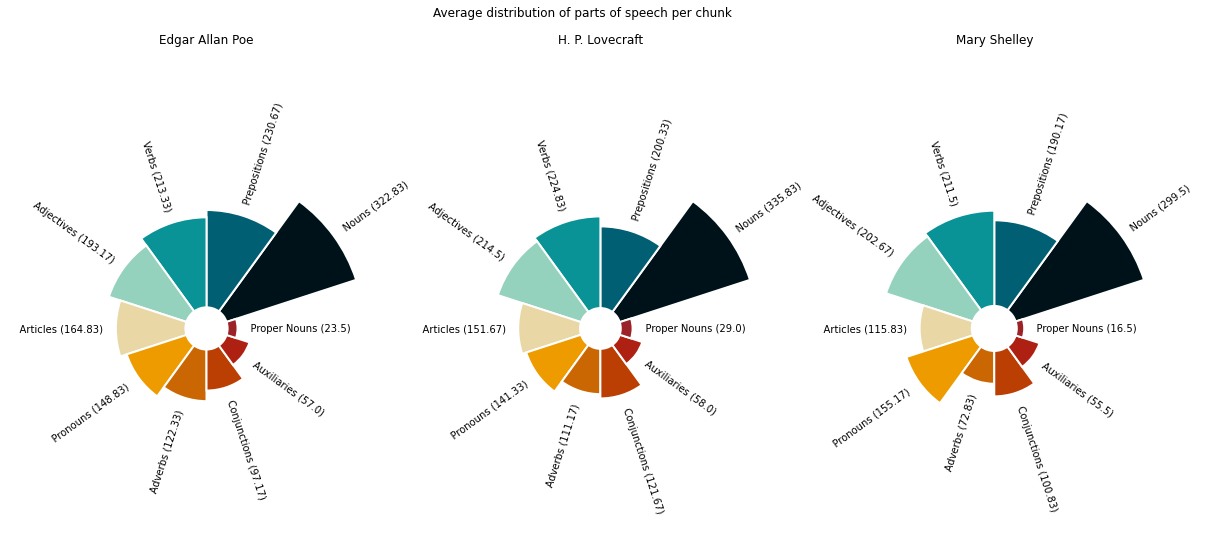

In [11]:
DEFAULT_COLORS = ["#001219", "#005f73", "#0a9396", "#94d2bd", "#e9d8a6", "#ee9b00",
                  "#ca6702", "#bb3e03", "#ae2012", "#9b2226", "#e2c2c6", "#b9929f",
                  "#9c528b", "#610f7f", "#2f0147", "#337357", "#00cc99", "#30bd6d",
                  "#5fad41", "#6d9f71"]


def circ_barplot(writeprints_list, wp_names, feature_names,
                 my_colors=None, plot_title="Features Comparison",
                 value="total", average=False, normalize=False, sort=True,
                 value_limit=0, center_limit=1, show_values=True):
    colors = [f"#{col_name}" for col_name in my_colors] if my_colors else DEFAULT_COLORS
    selected_dictionaries = writeprints_to_selected_dictionaries(writeprints_list,
                                                                 feature_names,
                                                                 value=value,
                                                                 average=average,
                                                                 normalize=normalize)
    if sort:
        selected_dictionaries = sort_dictionaries(selected_dictionaries)
    circ_barplot_fig = plt.figure(figsize=(20, 10))
    circ_barplot_fig.tight_layout()
    plt.suptitle(plot_title, y=0.95)
    num_barplot = 0
    for dictionary, person in zip(selected_dictionaries, wp_names):
        values, labels = make_values_labels(dictionary, value_limit)
        one_barplot = plt.subplot(1, len(wp_names), num_barplot + 1, polar=True)
        width = 2 * np.pi / len(values)
        indexes = list(range(1, len(values) + 1))
        angles = [element * width for element in indexes]
        bars = one_barplot.bar(x=angles,
                            height=values,
                            width=width,
                            bottom=center_limit,
                            color=colors,
                            linewidth=2,
                            edgecolor="white")
        plt.title(person, y=1.35)
        plt.axis("off")
        label_padding = 0.4
        for bar, angle, value, label in zip(bars, angles, values, labels):
            rotation = np.rad2deg(angle)
            if np.pi / 2 <= angle < 3 * np.pi / 2:
                alignment = "right"
                rotation = rotation + 180
            else:
                alignment = "left"
            one_barplot.text(x=angle,
                          y=center_limit + bar.get_height() + label_padding,
                          s=f"    {label} ({round(value, 2)})    " if show_values else f"    {label}    ",
                          ha=alignment,
                          va="center",
                          rotation=rotation,
                          rotation_mode="anchor")
        num_barplot += 1
    plt.show()
    return circ_barplot_fig


circ_barplot(spooky_writeprints, spooky_names, POS, value="total",
             normalize=False, average=True, center_limit=50,
             value_limit=1, plot_title="Average distribution of parts of speech per chunk")

## Stacked Bar Plots

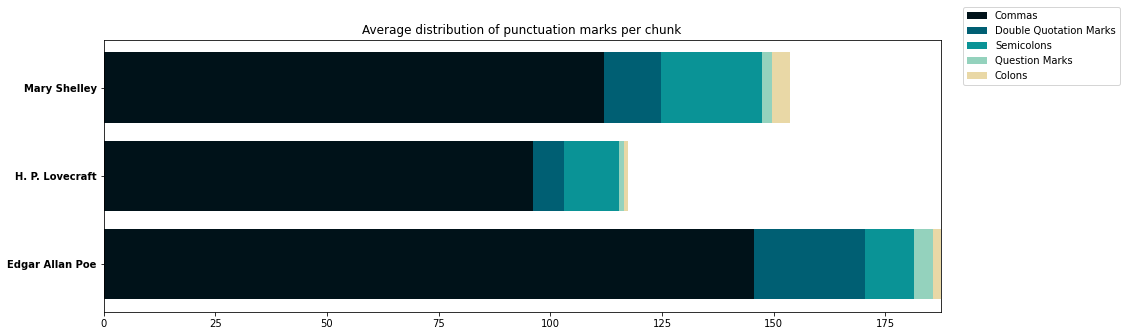

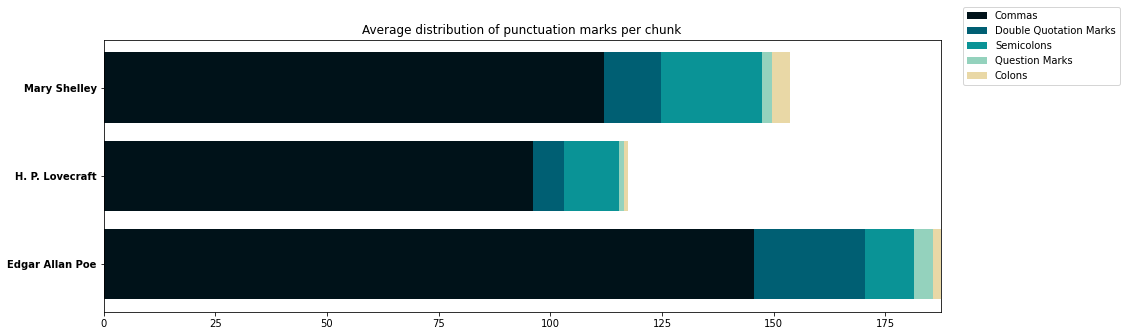

In [12]:
def stacked_bars(writeprints_list, wp_names, feature_names,
                 my_colors=None,
                 plot_title="Features Comparison",
                 value="total", average=False, sort=True,
                 normalize=False, value_limit=-1):
    selected_dictionaries = writeprints_to_selected_dictionaries(writeprints_list,
                                                                 feature_names,
                                                                 value=value,
                                                                 average=average,
                                                                 normalize=normalize)
    if sort:
        selected_dictionaries = sort_dictionaries(selected_dictionaries)
    stacked_bars_figure = plt.figure(figsize=(15, 5))
    colors = [f"#{col_name}" for col_name in my_colors] if my_colors else DEFAULT_COLORS
    feature_bars = []
    labels = []
    values = []
    for dictionary, person in zip(selected_dictionaries, wp_names):
        values, labels = make_values_labels(dictionary, value_limit=value_limit)
        feature_bars.append(values)
    all_bars = []
    for value in range(len(values)):
        bar_heights = []
        for name in range(len(wp_names)):
            bar_heights.append(feature_bars[name][value])
        all_bars.append(bar_heights)
    bar_bottoms = [0]*len(wp_names)
    bar_num = 0
    for bar_set in all_bars:
        plt.barh(range(len(wp_names)), bar_set, left=bar_bottoms, color=colors[bar_num])
        bar_bottoms = np.add(bar_bottoms, bar_set).tolist()
        bar_num += 1
    plt.legend(labels, loc="upper right", bbox_to_anchor=(1.22, 1.14))
    plt.title(plot_title)
    plt.margins(x=0, tight=False)
    plt.yticks(range(len(wp_names)), wp_names, fontweight="bold")
    plt.show()
    return stacked_bars_figure


stacked_bars(spooky_writeprints, spooky_names, PUNCTUATION_SHORT, value="total",
             value_limit=0, average=True, normalize=False,
             plot_title="Average distribution of punctuation marks per chunk")

## Donut Charts

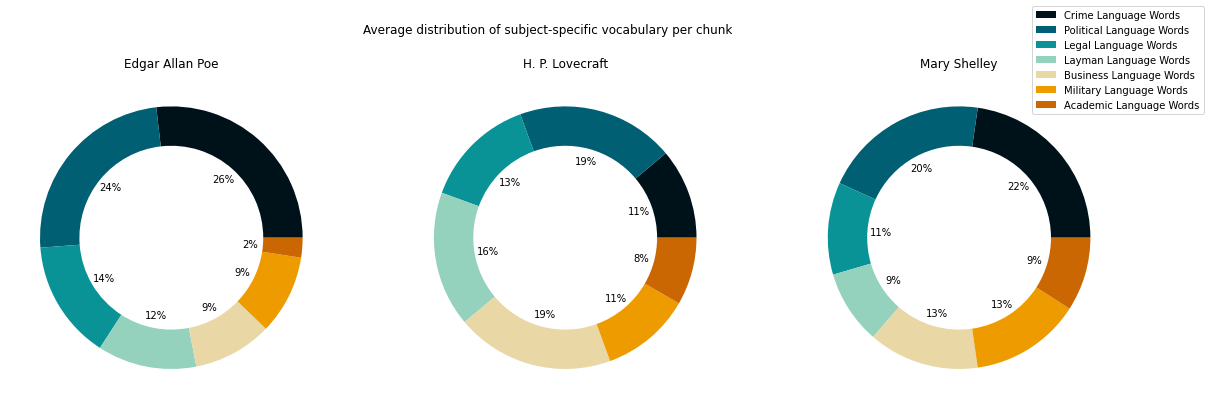

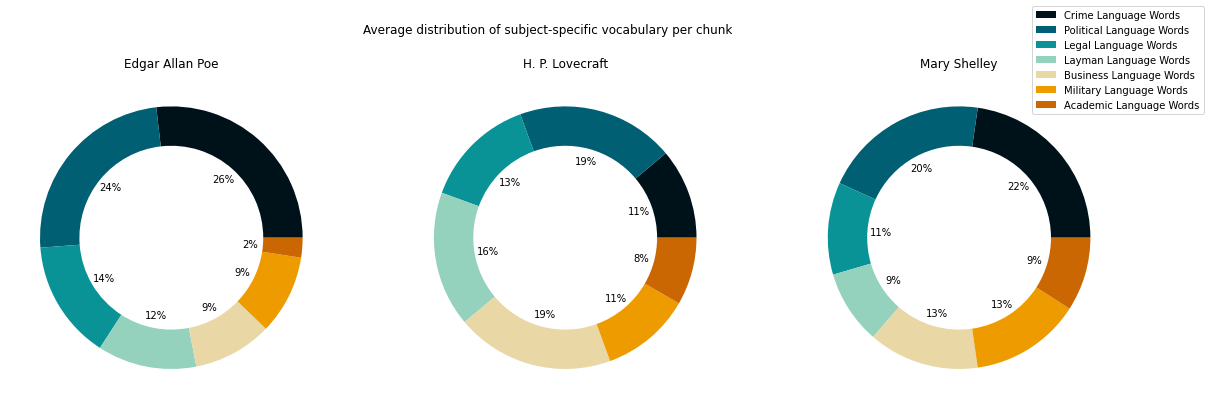

In [13]:
def donut(writeprints_list, wp_names, feature_names,
          my_colors=None,
          plot_title="Features comparison", value="mean", average=True,
          normalize=False, sort=True, value_limit=0):
    colors = [f"#{col_name}" for col_name in my_colors] if my_colors else DEFAULT_COLORS
    selected_dictionaries = writeprints_to_selected_dictionaries(
        writeprints_list, feature_names, value=value, average=average, normalize=normalize)
    if sort:
        selected_dictionaries = sort_dictionaries(selected_dictionaries)
    donut_figure = plt.figure(figsize=(20, 10))
    plt.suptitle(plot_title, y=0.80)
    num_pie = 0
    labels = []
    for dictionary, person in zip(selected_dictionaries, wp_names):
        values, labels = make_values_labels(dictionary, value_limit)
        one_pie = plt.subplot(1, len(wp_names), num_pie + 1)
        one_pie.pie(values, colors=colors, autopct="%d%%", wedgeprops=dict(width=.3))
        one_pie.title.set_text(person)
        num_pie += 1
    plt.legend(labels, loc="upper right", bbox_to_anchor=(1.26, 1.22))
    plt.show()
    return donut_figure


donut(spooky_writeprints, spooky_names, VOCABULARY_SHORT,
      value="total", average=True, normalize=False, sort=True,
      plot_title="Average distribution of subject-specific vocabulary per chunk")

## Treemap Charts

<Figure size 432x288 with 0 Axes>

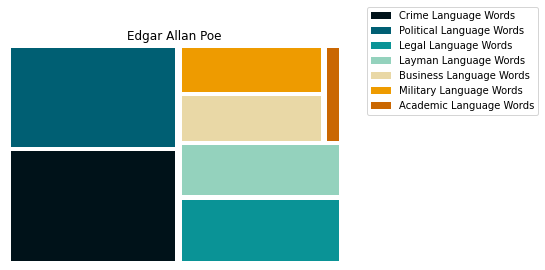

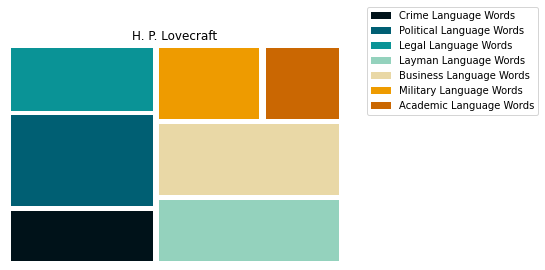

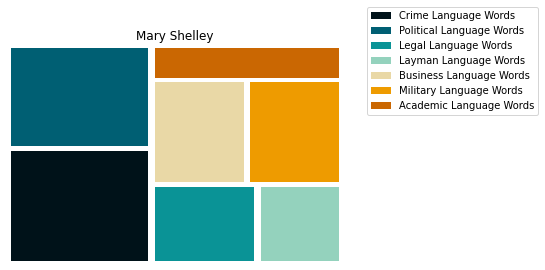

[<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>]

In [14]:
def treemap(writeprints_list, wp_names, feature_names,
            my_colors=None,
            plot_title="Features Comparison",
            value="total", average=False,
            normalize=False, sort=True,
            value_limit=0):
    colors = [f"#{col_name}" for col_name in my_colors] if my_colors else DEFAULT_COLORS
    selected_dictionaries = writeprints_to_selected_dictionaries(writeprints_list,
                                                                 feature_names,
                                                                 value=value,
                                                                 average=average,
                                                                 normalize=normalize)
    if sort:
        selected_dictionaries = sort_dictionaries(selected_dictionaries)
    plt.suptitle(plot_title, y=1.1)
    treemap_figures = []
    for dictionary, person in zip(selected_dictionaries, wp_names):
        treemap_figure = plt.figure()
        values, labels = make_values_labels(dictionary, value_limit)
        ax = squarify.plot(sizes=values, color=colors, pad=1)
        ax.get_xaxis().set_visible(False)
        plt.title(person)
        plt.legend(handles=ax.containers[0],
                   labels=labels,
                   bbox_to_anchor=(1.6, 1.2),
                   loc="upper right")
        plt.axis("off")
        plt.show()
        treemap_figures.append(treemap_figure)
    return treemap_figures

treemap(spooky_writeprints, spooky_names, VOCABULARY_SHORT, value="total",
        average=False, normalize=False, sort=True,
        plot_title="Total distribution of subject-specific vocabulary per author")

## Radar Charts

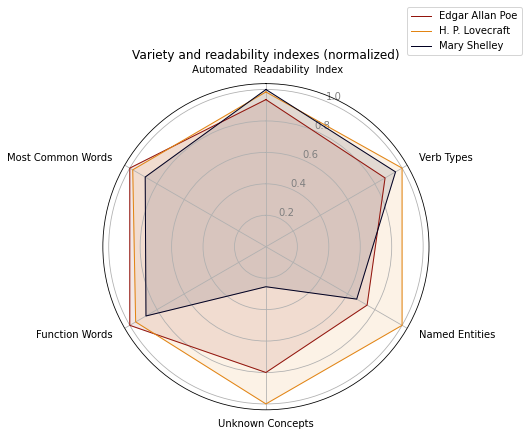

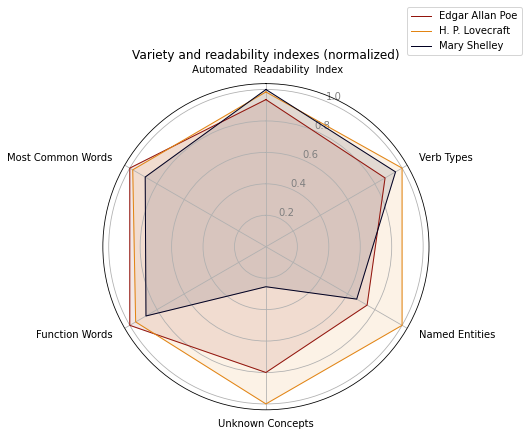

In [15]:
def radar(writeprints_list, wp_names, feature_names,
          my_colors=None,
          plot_title="Features Comparison",
          value="total", average=False,
          normalize=True, sort=False,
          value_limit=0):
    selected_dictionaries = writeprints_to_selected_dictionaries(writeprints_list,
                                                                 feature_names, value=value,
                                                                 average=average,
                                                                 normalize=normalize)
    colors = [f"#{col_name}" for col_name in my_colors] if my_colors else DEFAULT_COLORS
    if sort:
        selected_dictionaries = sort_dictionaries(selected_dictionaries)
    radar_figure, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    color_no = 0
    angles = []
    for dictionary, person in zip(selected_dictionaries, wp_names):
        values, labels = make_values_labels(dictionary, value_limit)
        values += values[:1]
        angles = [n / float(len(labels)) * 2 * np.pi for n in range(len(labels))]
        angles += angles[:1]
        color = colors[color_no]
        ax.plot(angles, values, linewidth=1, linestyle="solid", color=color, label=person)
        ax.fill(angles, values, "b", alpha=0.1, color=color)
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        ax.set_thetagrids(np.degrees(angles[:-1]), labels)
        for label, angle in zip(ax.get_xticklabels(), angles):
            if angle in (0, np.pi):
                label.set_horizontalalignment("center")
            elif 0 < angle < np.pi:
                label.set_horizontalalignment("left")
            else:
                label.set_horizontalalignment("right")
        color_no += 1
    ax.tick_params(axis="y", labelsize=10, colors="grey")
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.25))
    plt.xticks(angles[:-1])
    plt.title(plot_title)
    plt.show()
    return radar_figure

radar(spooky_writeprints, spooky_names, [*VARIETY, "Automated Readability Index"],
      value="total", average=False, normalize=True,
      my_colors=["92140c","e28413","000022"],
      plot_title="Variety and readability indexes (normalized)")

## Bar Plots for Individual Features

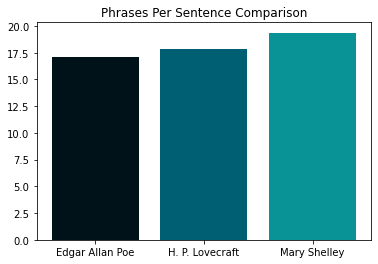

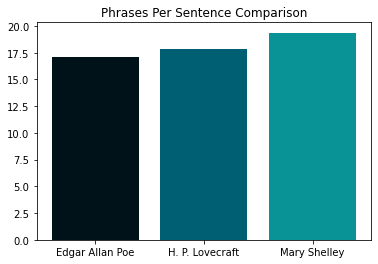

In [16]:
def barplot_one_feature(writeprints_list, wp_names, feature_name,
                        my_colors=None,
                        plot_title="", value="mean", average=True):
    colors = [f"#{col_name}" for col_name in my_colors] if my_colors else DEFAULT_COLORS
    barplot_figure = plt.figure()
    selected_dictionaries = writeprints_to_selected_dictionaries(writeprints_list,
                                                                 feature_name,
                                                                 value=value,
                                                                 average=average)
    feature_values = [dictionary[feature_name] for dictionary in selected_dictionaries]
    plt.bar(wp_names, feature_values, color=colors)
    fixed_name = re.sub(r"([A-Z])", r" \1", feature_name).title()
    plt.title(plot_title if plot_title != "" else f"{fixed_name} Comparison")
    plt.show()
    return barplot_figure

barplot_one_feature(spooky_writeprints, spooky_names,
                    "phrasesPerSentence", value="mean", average=True)

## Bar Plots for All the Features

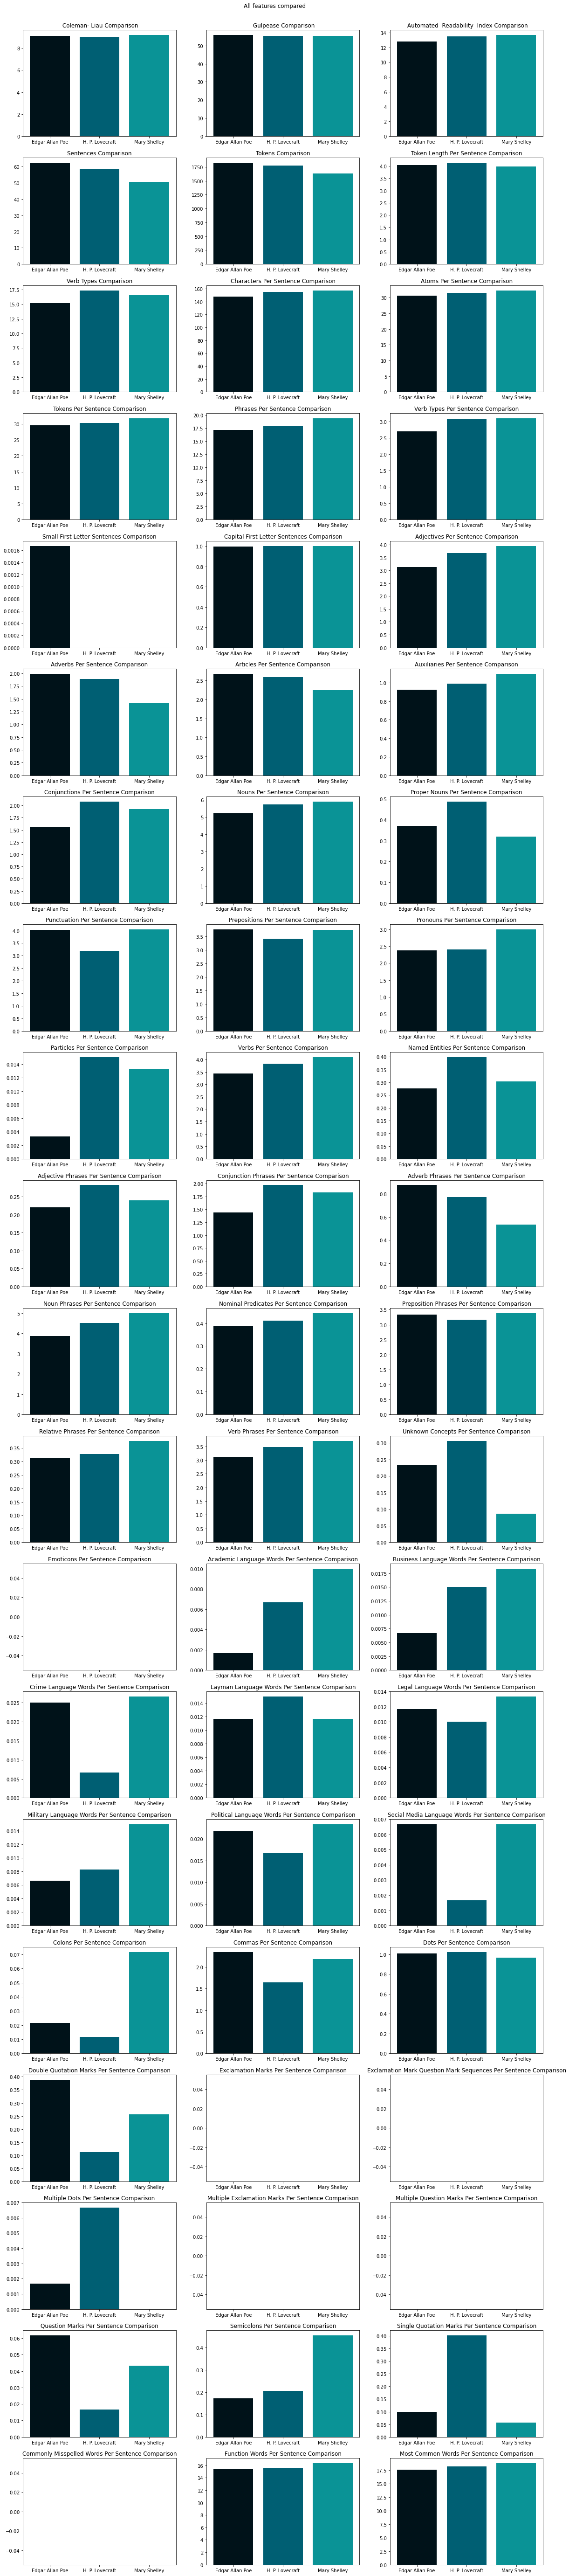

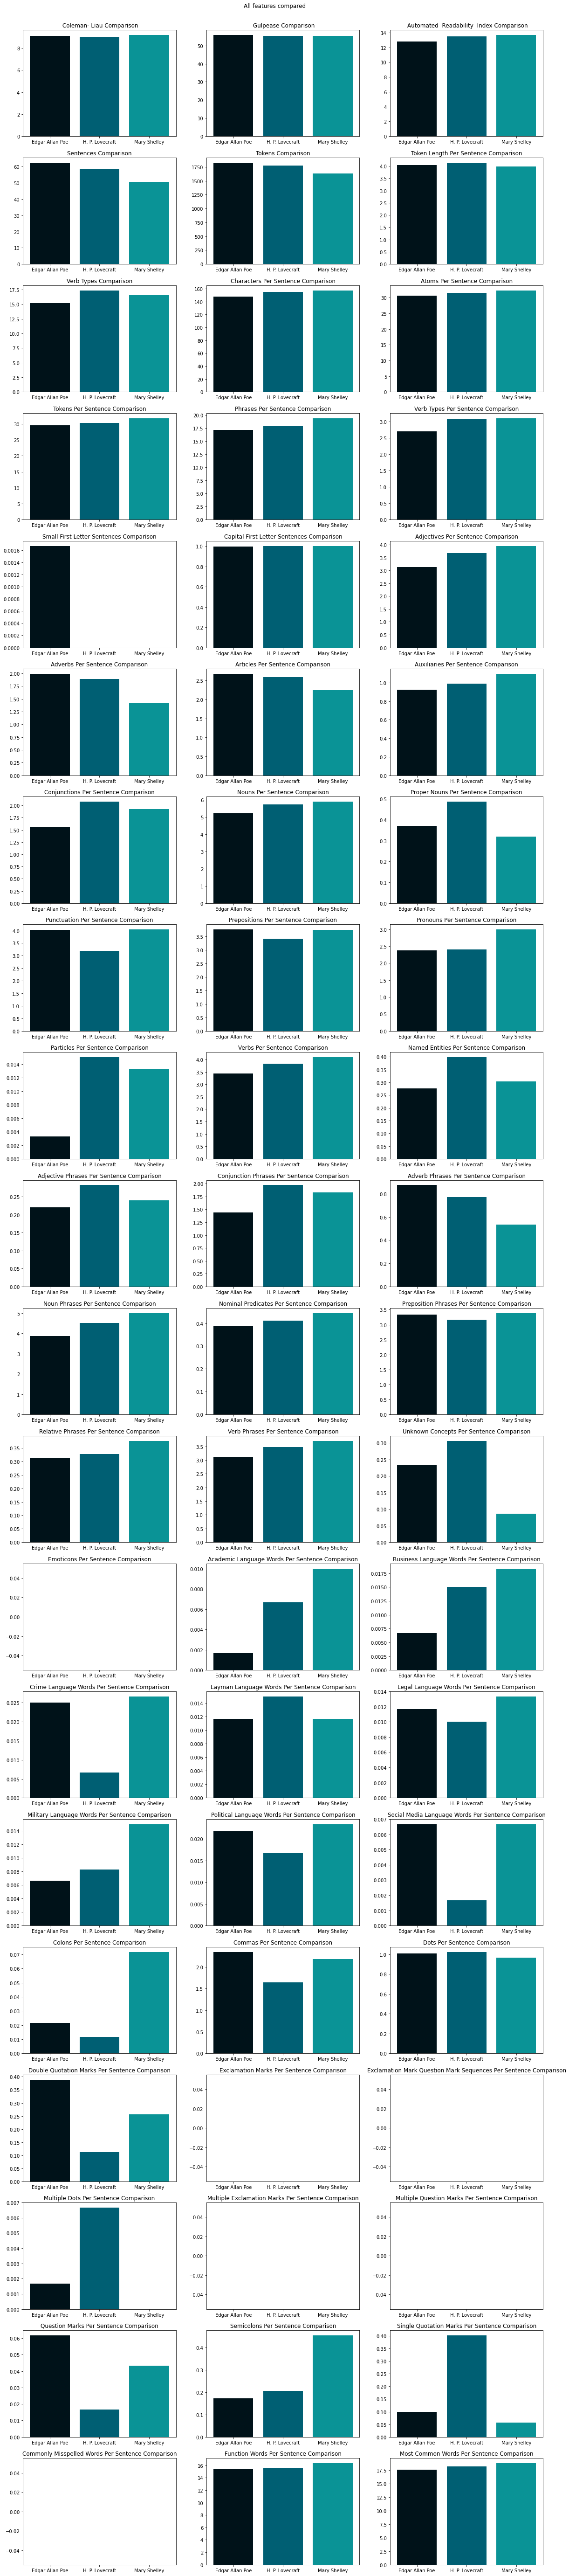

In [17]:
def barplot_all_features(writeprints_list, wp_names,
                         my_colors=None,
                         plot_title="All features compared", value="mean", average=True):
    colors = [f"#{col_name}" for col_name in my_colors] if my_colors else DEFAULT_COLORS
    writeprint_dictionaries = writeprints_to_dictionary(writeprints_list,
                                                        value=value,
                                                        average=average)
    barplots_figure = plt.figure(figsize=(20, 100))
    plt.suptitle(plot_title, y=0.888)
    num_barplot = 0
    for feature_name in list(writeprint_dictionaries[0].keys()):
        one_barplot = plt.subplot(20, 3, num_barplot + 1)
        feature_values = [dictionary[feature_name] for dictionary in writeprint_dictionaries]
        one_barplot.bar(wp_names, feature_values, color=colors)
        fixed_name = re.sub(r"([A-Z])", r" \1", feature_name).title()
        if value == "total":
            fixed_name = re.sub(r"Per Sentence", "Count", fixed_name)
        one_barplot.title.set_text(f"{fixed_name} Comparison")
        num_barplot += 1
    plt.show()
    return barplots_figure


barplot_all_features(spooky_writeprints, spooky_names)

## Prepare a Full Report

This function prepares a full stylometric report containing all the graphs above. It also prints them out in a single .pdf file. 

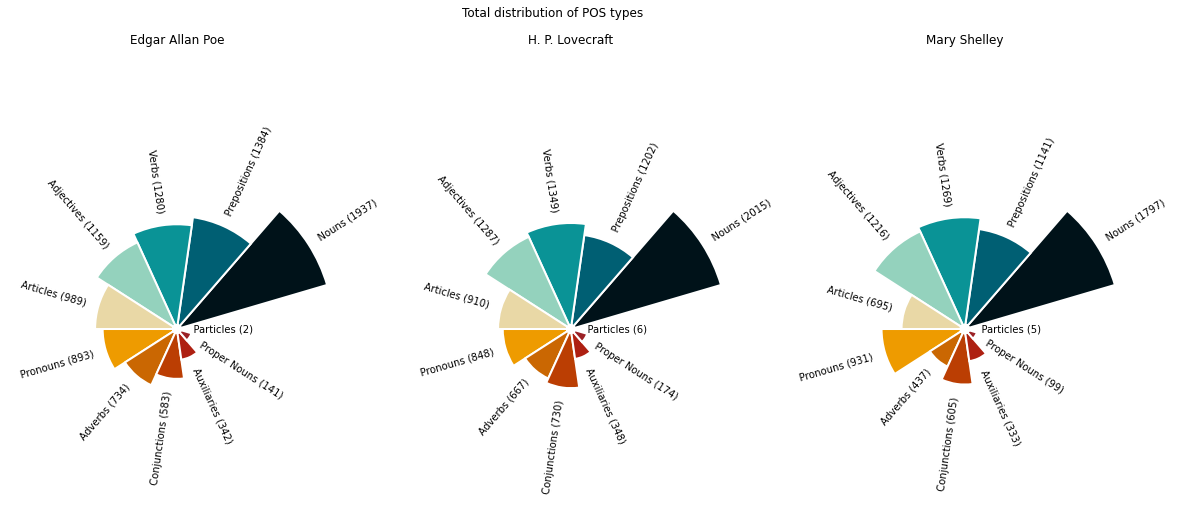

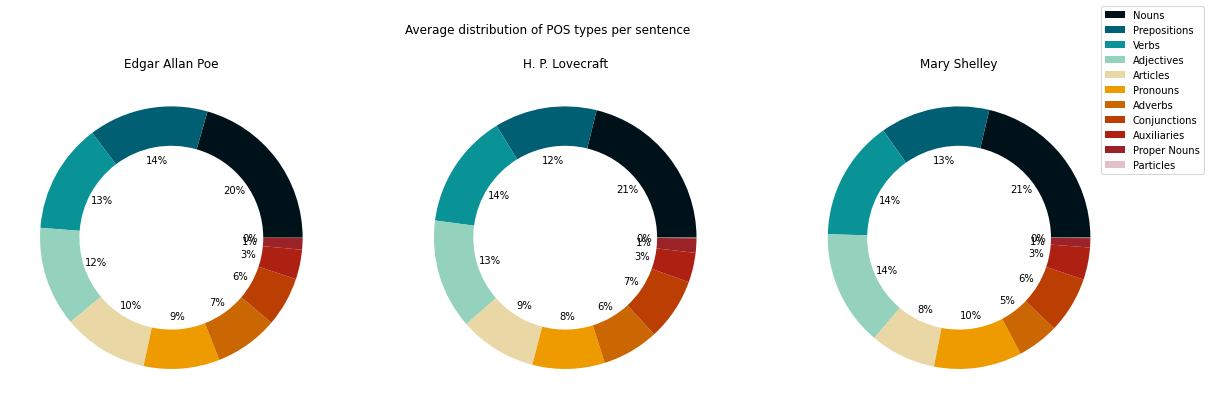

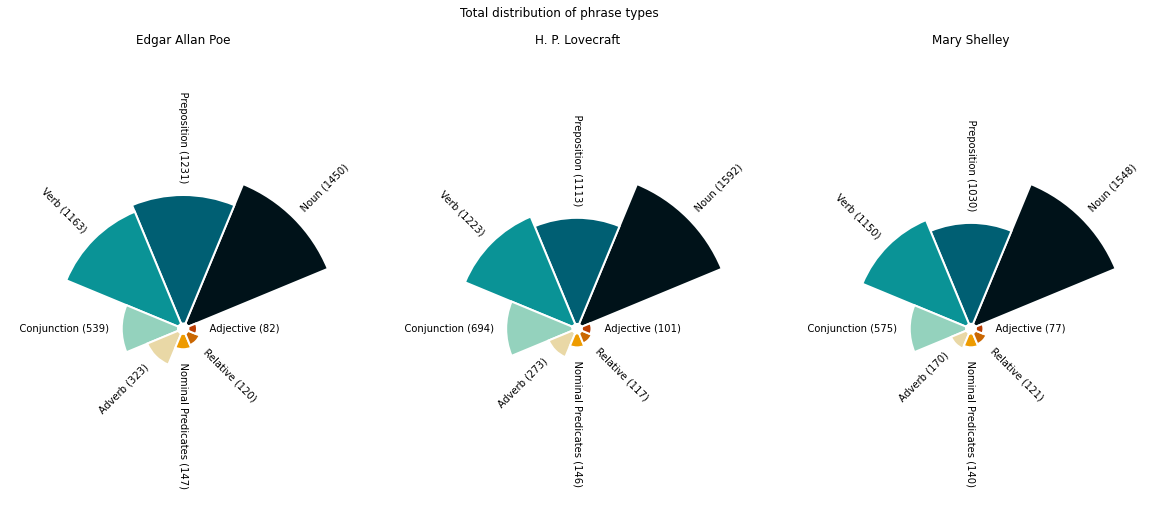

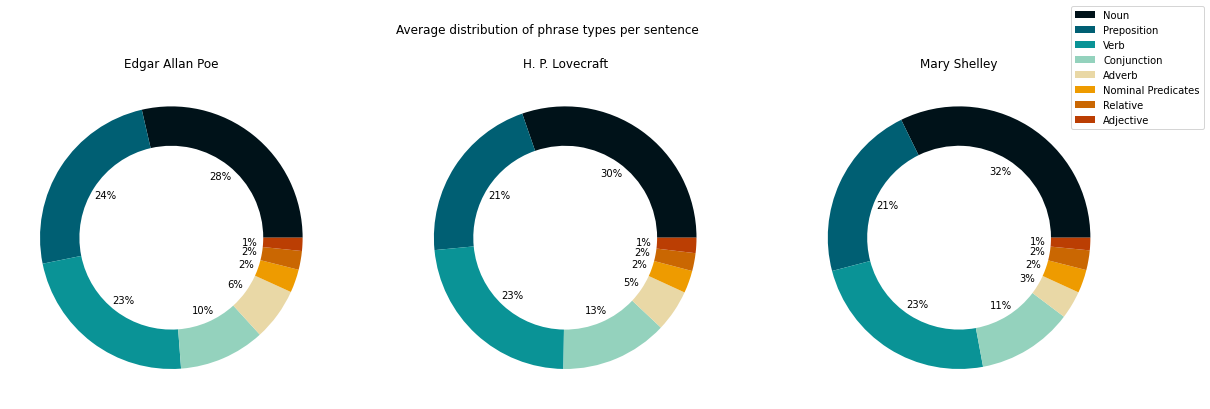

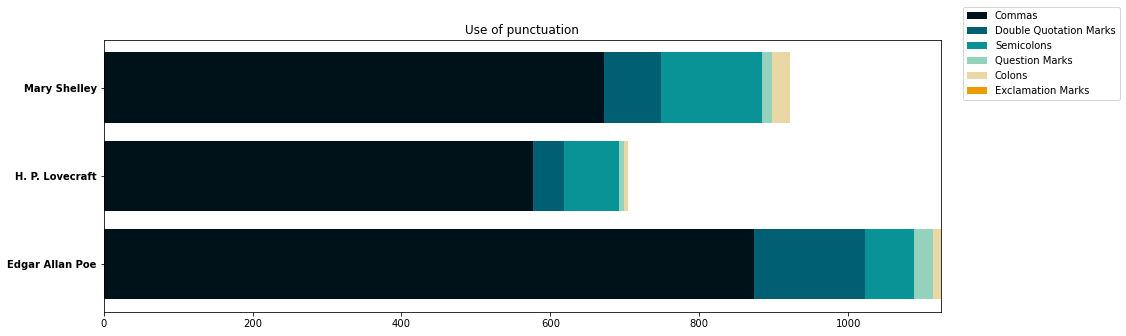

<Figure size 432x288 with 0 Axes>

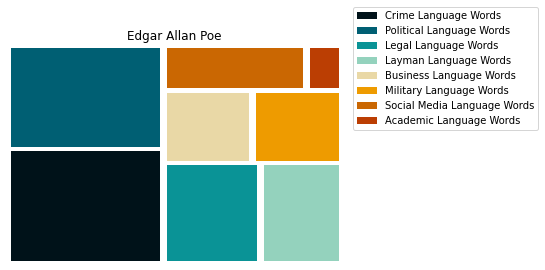

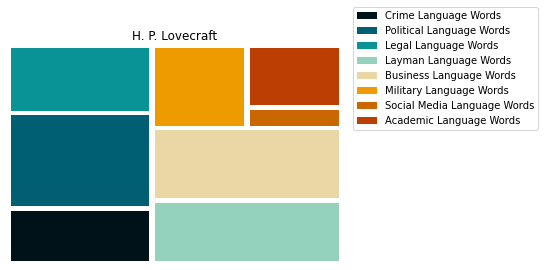

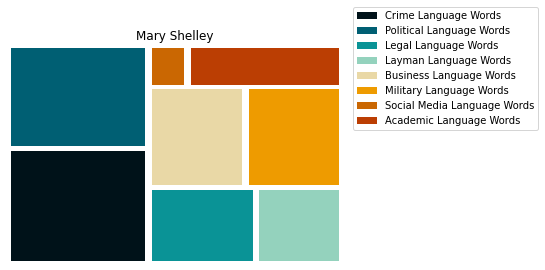

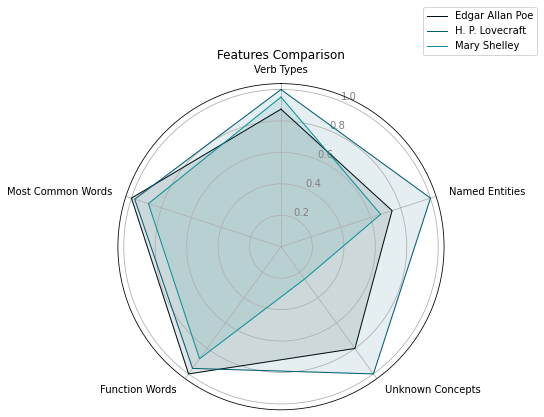

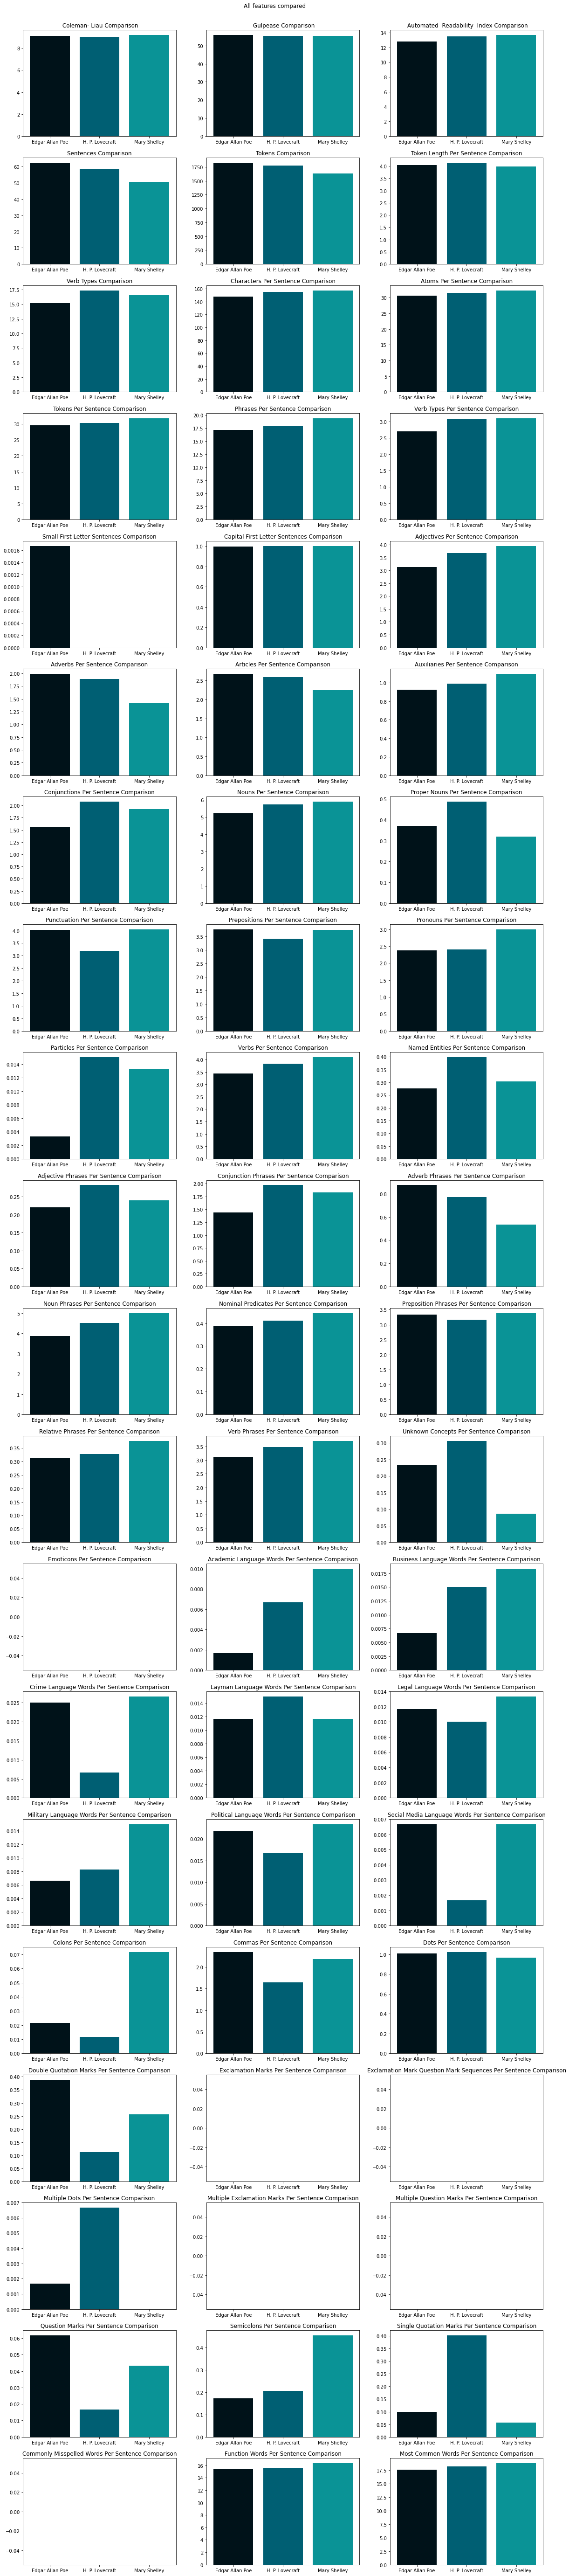

In [18]:
def make_full_report(multiple_wps, names):
    with PdfPages(f'Full report for {" ".join(names)}.pdf') as pdf:
        pdf.savefig(circ_barplot(multiple_wps, names, POS,
                                 plot_title="Total distribution of POS types",
                                 value="total", average=False, normalize=False, center_limit=50))
        pdf.savefig(donut(multiple_wps, names, POS,
                          plot_title="Average distribution of POS types per sentence",
                          value="mean", average=True, normalize=False),
                    bbox_inches="tight", pad_inches=3)
        pdf.savefig(circ_barplot(multiple_wps, names, PHRASES,
                                 plot_title="Total distribution of phrase types",
                                 value="total", average=False, normalize=False, center_limit=50),
                    bbox_inches="tight", pad_inches=3)
        pdf.savefig(donut(multiple_wps, names, PHRASES,
                          plot_title="Average distribution of phrase types per sentence",
                          value="mean", average=True, normalize=False),
                    bbox_inches="tight",
                    pad_inches=3)
        pdf.savefig(stacked_bars(multiple_wps, names, PUNCTUATION_SHORT,
                                 plot_title="Use of punctuation", value="total", average=False,
                                 normalize=False), bbox_inches="tight", pad_inches=3)
        for fig in treemap(multiple_wps, names, VOCABULARY,
                           plot_title="Presence of specific vocabulary", value="total",
                           average=False, normalize=False):
            pdf.savefig(fig, bbox_inches="tight", pad_inches=3)
        pdf.savefig(radar(multiple_wps, names, [*VARIETY], value="total",
                          average=True, normalize=True, value_limit=0),
                    bbox_inches="tight", pad_inches=3)
        pdf.savefig(barplot_all_features(multiple_wps, names), bbox_inches="tight")
        return pdf
    

make_full_report(spooky_writeprints, spooky_names)